<a href="https://colab.research.google.com/github/kithmini-wijesiri/De-Novo-Molecular-Generation-using-gflownet/blob/main/gflownet_getting_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting to know `gflownet`

Training GFlowNet gflownet library on molecular generation tasks, including, building a model, sampling from it, and training it.

Main classes used in the repo
Use a Trainer to train a model to generate fragment-based molecules
Look into graph policies and graph action categorical
Look at what Tasks are and how to make our own
Generate very ring-y atom-based molecules

In [ ]:
# The tag points to v0.2.0
!pip install --no-deps git+https://github.com/recursionpharma/gflownet.git@f106cde
!pip install torch_geometric torch_sparse torch_scatter rdkit gitpython omegaconf wandb --find-links https://data.pyg.org/whl/torch-2.3.0+cu121.html
!pip install botorch gpytorch linear_operator jaxtyping pyro-ppl --no-deps

In [ ]:
# Install specific versions of PyTorch and PyTorch Geometric
!pip install torch==2.1.2+cu121 torchvision==0.14.0+cu121 torchaudio==2.3.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-geometric==2.4.0

In [ ]:
import torch
print(torch.__version__)

2.4.0+cu121


In [ ]:
assert torch.__version__.startswith('2.4') and 'cu121' in torch.__version__, "The Colab torch version has changed, you may need to edit the !pip install cell to install matching torch_geometric versions"

In [ ]:
!pip install torch_geometric torch_sparse torch_scatter --find-links https://data.pyg.org/whl/torch-2.4.0+cu121.html

In [ ]:
!pip uninstall torch-scatter torch-sparse torch-geometric -y
!pip install torch-scatter torch-sparse torch-geometric --find-links https://data.pyg.org/whl/torch-2.4.0+cu121.html

In [ ]:
import torch_scatter
import torch_sparse
import torch_geometric
print(torch_scatter.__version__)
print(torch_sparse.__version__)
print(torch_geometric.__version__)

2.1.2+pt24cu121
0.6.18+pt24cu121
2.4.0


In [ ]:
# Let's import the stuff we need
import torch
from gflownet.config import init_empty, Config
from gflownet.models.graph_transformer import GraphTransformerGFN
from gflownet.envs.graph_building_env import GraphBuildingEnv
from gflownet.envs.frag_mol_env import FragMolBuildingEnvContext
from gflownet.algo.trajectory_balance import TrajectoryBalance

In the next cell we will initialize the basic blocks we need and just use default values everywhere:
- the `Config` is where hyperparameters are set (e.g. number of GNN layers, log directory, and so on)
- the `GraphBuildingEnv` is an high-level agnostic graph-handling environment
- the `-Context` class defines an "implementation" of the environment, it says what the graphs correspond to (in this case graphs of fragments)
- the model, is our main model; for GFlowNet it can output $P_F$, $F(s)$ or even $\log Z$
- the `algo`, `TrajectoryBalance`, defines how to (a) sample a model (b) construct a training batch and (c) train a model

In [ ]:
torch.manual_seed(1)  # For demonstration purposes
cfg = Config()
env = GraphBuildingEnv()
ctx = FragMolBuildingEnvContext()
model = GraphTransformerGFN(ctx, cfg)
algo = TrajectoryBalance(env, ctx, cfg)

Let's load CUDA if we can:

In [ ]:
if torch.cuda.is_available():
    from gflownet.utils.misc import set_main_process_device
    model.cuda()
    dev = torch.device('cuda')
    set_main_process_device(dev)
else:
    dev = torch.device('cpu')
dev

device(type='cuda')

Now, let's sample our model to see what comes out.

In [ ]:
trajs = algo.create_training_data_from_own_samples(model, 4)  # Sample 4 trajectories

In [ ]:
for state, action in trajs[0]['traj']:
    print(state, action)

<[], [], []> <GraphActionType.AddNode, 0, 22>
<[0], [], [22]> <GraphActionType.AddNode, 0, 11>
<[0, 1], [(0, 1)], [22, 11]> <GraphActionType.SetEdgeAttr, 0, 1, dst_attach, 4>
<[0, 1], [(0, 1)], [22, 11]> <GraphActionType.AddNode, 1, 6>
<[0, 1, 2], [(0, 1), (1, 2)], [22, 11, 6]> <GraphActionType.AddNode, 1, 37>
<[0, 1, 2, 3], [(0, 1), (1, 2), (1, 3)], [22, 11, 6, 37]> <GraphActionType.AddNode, 1, 16>
<[0, 1, 2, 3, 4], [(0, 1), (1, 2), (1, 3), (1, 4)], [22, 11, 6, 37, 16]> <GraphActionType.AddNode, 1, 43>
<[0, 1, 2, 3, 4, 5], [(0, 1), (1, 2), (1, 3), (1, 4), (1, 5)], [22, 11, 6, 37, 16, 43]> <GraphActionType.SetEdgeAttr, 1, 4, src_attach, 3>
<[0, 1, 2, 3, 4, 5], [(0, 1), (1, 2), (1, 3), (1, 4), (1, 5)], [22, 11, 6, 37, 16, 43]> <GraphActionType.SetEdgeAttr, 1, 5, dst_attach, 0>
<[0, 1, 2, 3, 4, 5], [(0, 1), (1, 2), (1, 3), (1, 4), (1, 5)], [22, 11, 6, 37, 16, 43]> <GraphActionType.SetEdgeAttr, 1, 2, src_attach, 1>
<[0, 1, 2, 3, 4, 5], [(0, 1), (1, 2), (1, 3), (1, 4), (1, 5)], [22, 11, 6,

We obtain trajectories, which are sequences of states and actions. Notice here that, since we produce a fragment graph in the form of a junction tree, the agent is only allow to `AddNode` (attach a new fragment node to an existing node), and `SetEdgeAttr` (in the fragment case, set which atom in the fragment molecule is used in the bond). It can also end the trajectory by using the `Stop` action.

Let's see what's being produced. We can do so by asking the Context class to map our abstract `Graph`s back to whatever object type the context deals with (in this case, rdkit molecules).

In [ ]:
mol = ctx.graph_to_obj(trajs[0]['result'])

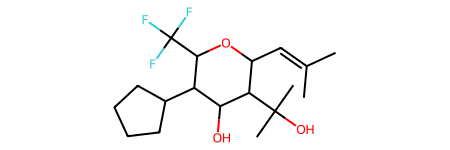

In [ ]:
mol  # An rdkit molecule

It's great that we can produce molecules, but to train our GFlowNet, we're going to need a reward function.

In this library, these come in the form of Tasks. A task defines not only the reward function, but also is able to things like distributions of conditional information (we will come back to this later). Let's use the task the GFlowNets were developed for, `SEHTask`, which rewards molecules with a high binding affinity to the sEH protein.

In [ ]:
from gflownet.tasks.seh_frag import SEHTask
task = SEHTask(cfg)

We can now ask the task to compute rewards; note that we first have to convert the graphs into objects.

Parenthesis: we also have to specify the `beta` conditional. In `SEHTask` the model is trained to match $\hat R = R(x)^\beta$. This inverse temperature parameter allows the model to be greedier and better focus on the high reward molecules of the (very large) state space.

In [ ]:
objs = [ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, _ = task.compute_obj_properties(objs)
log_rewards = task.cond_info_to_logreward({'beta': torch.ones(4)}, obj_props)

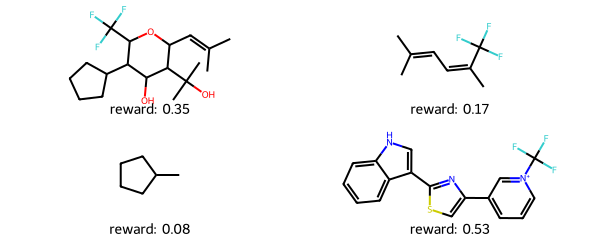

In [ ]:
from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage(objs, molsPerRow=2, subImgSize=(300, 120), legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards])

We have molecules, we have rewards, we can now train the model!

For this we have to construct a training batch from the trajectories. `TrajectoryBalance` will then compute the loss based it (and the `Config` we gave it).

In [ ]:
batch = algo.construct_batch(trajs, None, log_rewards).to(dev)
loss, info = algo.compute_batch_losses(model, batch)
loss

tensor(205.8346, device='cuda:0', grad_fn=<AddBackward0>)

We have a loss, now all we need is an optimizer.

In [ ]:
opt = torch.optim.Adam(model.parameters(), 3e-4)

In [ ]:
loss.backward()
opt.step()
opt.zero_grad()

We've trained our model on 4 trajectories. Let's train our model with $\beta=32$.

In [ ]:
try:
    from tqdm.notebook import tqdm
except:
    tdqm = lambda x: x
beta = 32
losses = []
avg_rewards = []
for i in tqdm(range(100)):
    with torch.no_grad():  # We don't need to compute gradients here, they will be later
        trajs = algo.create_training_data_from_own_samples(model, 64)

        objs = [ctx.graph_to_obj(i['result']) for i in trajs]
        obj_props, _ = task.compute_obj_properties(objs)
        log_rewards = task.cond_info_to_logreward({'beta': torch.ones(len(trajs)) * beta}, obj_props)

    batch = algo.construct_batch(trajs, None, log_rewards).to(dev)
    loss, _ = algo.compute_batch_losses(model, batch)
    loss.backward()
    opt.step()
    opt.zero_grad()

    losses.append(loss.item())
    avg_rewards.append((log_rewards / beta).exp().mean().item())

  0%|          | 0/100 [00:00<?, ?it/s]

What does this look like? Are we learning anything interesting within 100 steps?

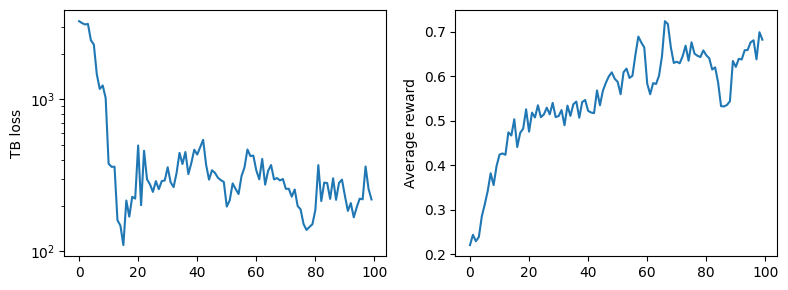

In [ ]:
import matplotlib.pyplot as pp
f, ax = pp.subplots(1, 2, figsize=(8,3))
ax[0].plot(losses)
ax[0].set_yscale('log')
ax[0].set_ylabel('TB loss')
ax[1].plot(avg_rewards)
ax[1].set_ylabel('Average reward')
pp.tight_layout()

Seem like the average reward is going up, and the loss is going down.

In [ ]:
objs = [ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, _ = task.compute_obj_properties(objs)
log_rewards = task.cond_info_to_logreward({'beta': torch.ones(len(trajs))}, obj_props)

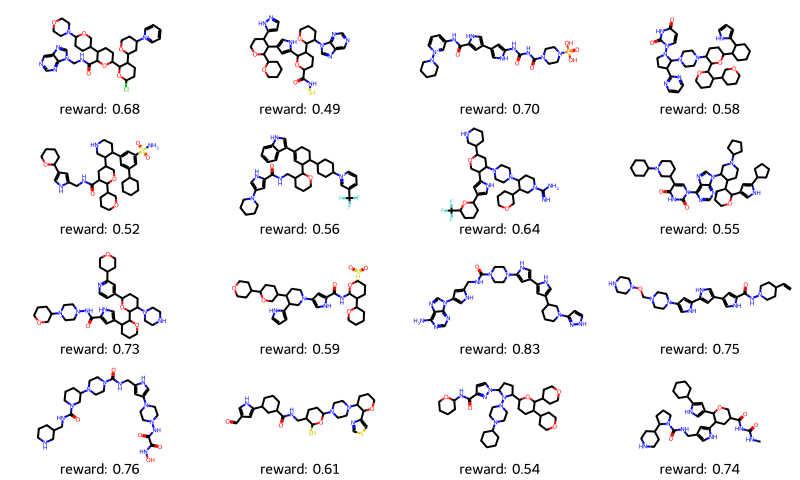

In [ ]:
from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage(objs[:16], molsPerRow=4, subImgSize=(200, 120), legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards[:16]])

## Using trainers

All of what we've just done (and more!) is handled by `GFNTrainer` classes. An equivalent way of doing the above would be to use the `SEHFragTrainer` class directly.

This allows us to do a few things better, for example, collect more statistics (e.g. the value of $\log Z$), or use workers to speed up the process.

In [ ]:
from gflownet.tasks.seh_frag import SEHFragTrainer

cfg = init_empty(Config())
# General setup of method and task
cfg.log_dir = './temp_log_dir'
cfg.overwrite_existing_exp = True
cfg.device = 'cuda'
cfg.algo.method = 'TB'   # We could also use SubTB, FM, ...
cfg.algo.num_from_policy = 64  # Here we're indicating that a training batch should contain 64 trajectories sampled from the policy
cfg.algo.sampling_tau = 0      # More on this later
cfg.cond.temperature.sample_dist = 'constant'  # Use a constant beta (reward inverse temperature)
cfg.cond.temperature.dist_params = [32]        # Use beta = 32
cfg.num_training_steps = 100   # Train for 100 steps, as we just did above (we'd normally train for much longer of course)
cfg.num_workers = 2      # Let's use 2 workers to accelerate trajectory sampling
cfg.print_every = 10     # print an update every 10 steps
cfg.pickle_mp_messages = True

# We can setup the model & learning parameters
cfg.opt.learning_rate = 3e-4
cfg.algo.tb.Z_learning_rate = 3e-4
cfg.opt.clip_grad_type = "none"
cfg.model.num_layers = 3
cfg.model.num_emb = 128

trainer = SEHFragTrainer(cfg, print_config=False)  # If set to True, this will print the entire config
trainer.run()

08/09/2024 21:03:42 - INFO - logger - Starting training


/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
INFO:logger:Starting training
/u

08/09/2024 21:04:07 - INFO - logger - iteration 10 : offline_loss:0.00 online_loss:894.10 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.10 loss:894.10 n_loss:0.00 tb_loss:894.10 batch_entropy:59.36 traj_lens:21.36 grad_norm:792.16 grad_norm_clip:792.16 sampled_reward_avg:0.30 train_time:0.16 time_spent:0.56


INFO:logger:iteration 10 : offline_loss:0.00 online_loss:894.10 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.10 loss:894.10 n_loss:0.00 tb_loss:894.10 batch_entropy:59.36 traj_lens:21.36 grad_norm:792.16 grad_norm_clip:792.16 sampled_reward_avg:0.30 train_time:0.16 time_spent:0.56


08/09/2024 21:04:29 - INFO - logger - iteration 20 : offline_loss:0.00 online_loss:174.13 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.25 loss:174.13 n_loss:0.00 tb_loss:174.13 batch_entropy:73.14 traj_lens:25.44 grad_norm:409.78 grad_norm_clip:409.78 sampled_reward_avg:0.47 train_time:0.16 time_spent:0.27


INFO:logger:iteration 20 : offline_loss:0.00 online_loss:174.13 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.25 loss:174.13 n_loss:0.00 tb_loss:174.13 batch_entropy:73.14 traj_lens:25.44 grad_norm:409.78 grad_norm_clip:409.78 sampled_reward_avg:0.47 train_time:0.16 time_spent:0.27


08/09/2024 21:04:53 - INFO - logger - iteration 30 : offline_loss:0.00 online_loss:363.50 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.23 loss:363.50 n_loss:0.00 tb_loss:363.50 batch_entropy:76.88 traj_lens:25.72 grad_norm:520.23 grad_norm_clip:520.23 sampled_reward_avg:0.54 train_time:0.24 time_spent:1.35


INFO:logger:iteration 30 : offline_loss:0.00 online_loss:363.50 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.23 loss:363.50 n_loss:0.00 tb_loss:363.50 batch_entropy:76.88 traj_lens:25.72 grad_norm:520.23 grad_norm_clip:520.23 sampled_reward_avg:0.54 train_time:0.24 time_spent:1.35


08/09/2024 21:05:18 - INFO - logger - iteration 40 : offline_loss:0.00 online_loss:326.87 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.13 loss:326.87 n_loss:0.00 tb_loss:326.87 batch_entropy:79.92 traj_lens:25.95 grad_norm:592.75 grad_norm_clip:592.75 sampled_reward_avg:0.53 train_time:0.14 time_spent:0.40


INFO:logger:iteration 40 : offline_loss:0.00 online_loss:326.87 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.13 loss:326.87 n_loss:0.00 tb_loss:326.87 batch_entropy:79.92 traj_lens:25.95 grad_norm:592.75 grad_norm_clip:592.75 sampled_reward_avg:0.53 train_time:0.14 time_spent:0.40


08/09/2024 21:05:41 - INFO - logger - iteration 50 : offline_loss:0.00 online_loss:370.58 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.02 loss:370.58 n_loss:0.00 tb_loss:370.58 batch_entropy:79.42 traj_lens:25.86 grad_norm:702.08 grad_norm_clip:702.08 sampled_reward_avg:0.56 train_time:0.26 time_spent:0.35


INFO:logger:iteration 50 : offline_loss:0.00 online_loss:370.58 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.02 loss:370.58 n_loss:0.00 tb_loss:370.58 batch_entropy:79.42 traj_lens:25.86 grad_norm:702.08 grad_norm_clip:702.08 sampled_reward_avg:0.56 train_time:0.26 time_spent:0.35


08/09/2024 21:06:07 - INFO - logger - iteration 60 : offline_loss:0.00 online_loss:298.15 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.09 loss:298.15 n_loss:0.00 tb_loss:298.15 batch_entropy:77.01 traj_lens:26.00 grad_norm:770.77 grad_norm_clip:770.77 sampled_reward_avg:0.58 train_time:0.14 time_spent:0.21


INFO:logger:iteration 60 : offline_loss:0.00 online_loss:298.15 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.09 loss:298.15 n_loss:0.00 tb_loss:298.15 batch_entropy:77.01 traj_lens:26.00 grad_norm:770.77 grad_norm_clip:770.77 sampled_reward_avg:0.58 train_time:0.14 time_spent:0.21


08/09/2024 21:06:29 - INFO - logger - iteration 70 : offline_loss:0.00 online_loss:353.47 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.22 loss:353.47 n_loss:0.00 tb_loss:353.47 batch_entropy:77.32 traj_lens:25.77 grad_norm:509.80 grad_norm_clip:509.80 sampled_reward_avg:0.59 train_time:0.12 time_spent:0.97


INFO:logger:iteration 70 : offline_loss:0.00 online_loss:353.47 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.22 loss:353.47 n_loss:0.00 tb_loss:353.47 batch_entropy:77.32 traj_lens:25.77 grad_norm:509.80 grad_norm_clip:509.80 sampled_reward_avg:0.59 train_time:0.12 time_spent:0.97


08/09/2024 21:06:54 - INFO - logger - iteration 80 : offline_loss:0.00 online_loss:395.20 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.41 loss:395.20 n_loss:0.00 tb_loss:395.20 batch_entropy:80.43 traj_lens:26.00 grad_norm:450.12 grad_norm_clip:450.12 sampled_reward_avg:0.57 train_time:0.14 time_spent:0.22


INFO:logger:iteration 80 : offline_loss:0.00 online_loss:395.20 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.41 loss:395.20 n_loss:0.00 tb_loss:395.20 batch_entropy:80.43 traj_lens:26.00 grad_norm:450.12 grad_norm_clip:450.12 sampled_reward_avg:0.57 train_time:0.14 time_spent:0.22


08/09/2024 21:07:15 - INFO - logger - iteration 90 : offline_loss:0.00 online_loss:481.66 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.71 loss:481.66 n_loss:0.00 tb_loss:481.66 batch_entropy:80.32 traj_lens:26.00 grad_norm:762.51 grad_norm_clip:762.51 sampled_reward_avg:0.61 train_time:0.14 time_spent:0.21


INFO:logger:iteration 90 : offline_loss:0.00 online_loss:481.66 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.71 loss:481.66 n_loss:0.00 tb_loss:481.66 batch_entropy:80.32 traj_lens:26.00 grad_norm:762.51 grad_norm_clip:762.51 sampled_reward_avg:0.61 train_time:0.14 time_spent:0.21


08/09/2024 21:07:40 - INFO - logger - iteration 100 : offline_loss:0.00 online_loss:453.72 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:1.13 loss:453.72 n_loss:0.00 tb_loss:453.72 batch_entropy:80.94 traj_lens:26.00 grad_norm:580.34 grad_norm_clip:580.34 sampled_reward_avg:0.60 train_time:0.20 time_spent:0.70


INFO:logger:iteration 100 : offline_loss:0.00 online_loss:453.72 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:1.13 loss:453.72 n_loss:0.00 tb_loss:453.72 batch_entropy:80.94 traj_lens:26.00 grad_norm:580.34 grad_norm_clip:580.34 sampled_reward_avg:0.60 train_time:0.20 time_spent:0.70


By default, `gflownet` outputs all training stats to a tensorboard file. If a `wandb` run is active, it will also log those values to it.

Let's take a look at those! In particular let's plot the loss, the average reward and the logZ estimate.

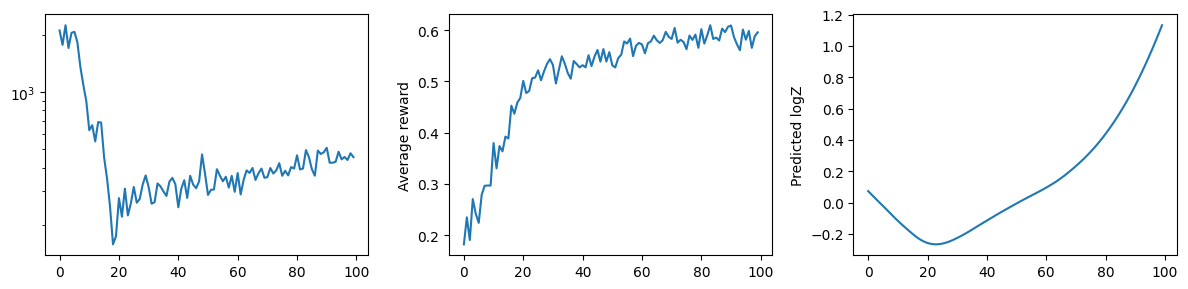

In [ ]:
from tensorboard.backend.event_processing import event_accumulator
cfg.log_dir = 'temp_log_dir'
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()

import matplotlib.pyplot as pp
f, ax = pp.subplots(1, 3, figsize=(4*3,3))
ax[0].plot([i.value for i in ea.Scalars('train_loss')])
ax[0].set_yscale('log')
ax[1].set_ylabel('TB loss')
ax[1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')])
ax[1].set_ylabel('Average reward')
ax[2].plot([i.value for i in ea.Scalars('train_logZ')])
ax[2].set_ylabel('Predicted logZ')
pp.tight_layout()

By default, `gflownet` also saves the objects generated by the models. Let's load them up.

In [ ]:
import importlib
import gflownet.utils.sqlite_log as sqll
importlib.reload(sqll)
results = sqll.read_all_results('./temp_log_dir/train/')
results

,smi,r,fr_0,ci_beta
0,C[SH+]N1C(N2C=CCC([N+](=O)[O-])=C2)CC(NCC2CNc3...,0.554716,0.554716,32.0
1,O=[N+]([O-])c1c[nH]c2ccccc12,0.292818,0.292818,32.0
2,CC(C)c1c[nH]c2ccccc12,0.308179,0.308179,32.0
3,CC(=O)NCl,0.023558,0.023558,32.0
4,C[SH+]n1ccc(-c2cc(C3CNc4nc[nH]c(=O)c4N3)c(-c3c...,0.012186,0.012186,32.0
...,...,...,...,...
6523,CC=CC1CCC=CC1C1C(C2CCCC(C(=O)NC)C2)CCC(c2cc(C(...,0.524494,0.524494,32.0
6524,C1=C(C2CNCCC2C2CCCC(NC[n+]3ccccc3)C2)CCC(c2c[n...,0.704790,0.704790,32.0
6525,O=[SH](=O)C1CN(c2csc(C3CCCC(c4cc(C5CCNCC5c5ccn...,0.738470,0.738470,32.0
6526,CC(C)=CC1CC(NCC2CCCC(C3CCCOC3)O2)CC(NC(=O)C2CO...,0.533449,0.533449,32.0


What are the best molecules we found?

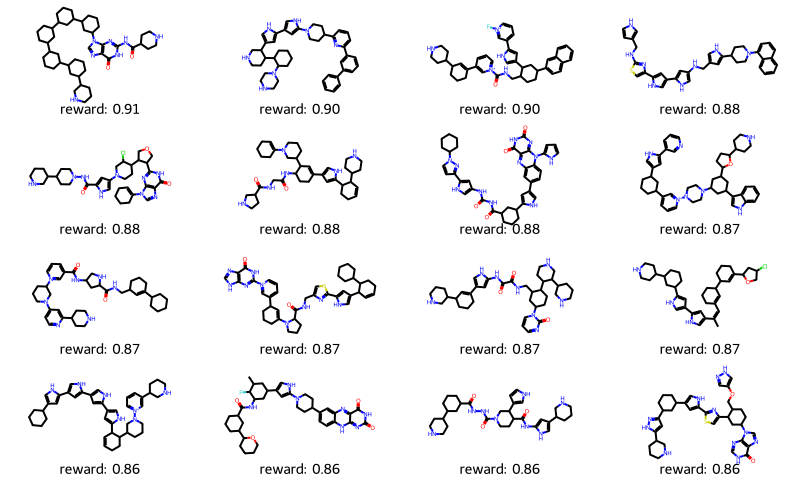

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
top_k = np.argsort(results['r'])[-16:][::-1]
rewards = results['r'][top_k]
mols = [Chem.MolFromSmiles(i) for i in results['smi'][top_k]]
MolsToGridImage(mols[:16], molsPerRow=4, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' for r in rewards])

# Digging in

## Graph models and Graph Actions
Let's take another look at what our models do and output, and start by manually creating a graph:

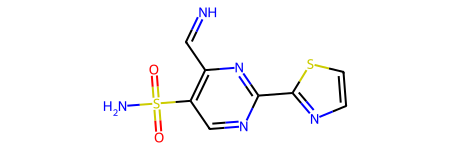

In [ ]:
g = env.new()
g.add_node(0, v=42)
g.add_node(1, v=69)
g.add_node(2, v=18)
g.add_node(3, v=70)
g.add_edge(0,1,src_attach=0,dst_attach=0)
g.add_edge(1,2,src_attach=1,dst_attach=0)
g.add_edge(1,3,src_attach=2,dst_attach=1)
ctx.graph_to_obj(g)

What does this graph look to our model? First we have to encode it

In [ ]:
data = ctx.graph_to_Data(g)
data

Data(x=[4, 73], edge_index=[2, 6], edge_attr=[6, 14], stop_mask=[1, 1], add_node_mask=[4, 72], set_edge_attr_mask=[3, 12], remove_node_mask=[4, 1], remove_edge_attr_mask=[3, 2])

The `x` tensor here is simply a one-hot encoding of the fragements' identity, but more generally could be any featurization of the nodes

In [ ]:
data.x.nonzero()

tensor([[ 0, 42],
        [ 1, 69],
        [ 2, 18],
        [ 3, 70]])

Note that the `Data` instance also provides us with masks. These tell us which actions are valid, for example, the `add_node_mask`, tells us that we can add more fragments to the second and fourth nodes, but not the other.

In [ ]:
data.add_node_mask, data.add_node_mask.shape

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1.,

Also note that there are 72 fragments available by default in `FragMolBuildingEnvContext`, thus 72 possible actions _for each node_.

Let's pass this input to the model to see what it outputs.

In [ ]:
batch = ctx.collate([data]).to(dev)  # minibatch of size 1
P_F, F = model(batch, None)
P_F, F

(<gflownet.envs.graph_building_env.GraphActionCategorical at 0x7e21f1c82bc0>,
 tensor([[0.6842]], device='cuda:0', grad_fn=<AddmmBackward0>))

Here we have two outputs, `P_F`, which is the forward policy, and `F` (only used for SubTB or DB). `F` is simply a tensor of scalars, nothing fancy, but `P_F` is more complicated since we need to handle:
- variable numbers of actions (due to the variable number of e.g. nodes in a graph)
- variable types of actions (e.g. `AddNode` or `AddEdge`)
- variable minibatch sizes

This is all handled by the `GraphActionCategorical` class.

Here, the available actions are

In [ ]:
model.action_type_order

[<GraphActionType.Stop: 1>,
 <GraphActionType.AddNode: 2>,
 <GraphActionType.SetEdgeAttr: 5>]

And so we get these three logit tensors:

In [ ]:
[i.shape for i in P_F.logits]

[torch.Size([1, 1]), torch.Size([4, 72]), torch.Size([3, 12])]

Which would yield the following probabilities:

In [ ]:
[i.exp() for i in P_F.logsoftmax()]

[tensor([[0.0003]], device='cuda:0', grad_fn=<ExpBackward0>),
 tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.

Note how, thanks to the masks, the probability of illegal actions is 0.

We can also sample from this distribution:

In [ ]:
P_F.sample()

[ActionIndex(action_type=1, row_idx=3, col_idx=19)]

Which gives us 3-tuples, which correspond to, in order, the index of the action type (as per `model.action_type_order`), the node/edge index that the action acts upon, and the "value" of the action.

For example, an action tuple (1,3,16) corresponds to attaching the 16th fragment to the 3rd node:

In [ ]:
from gflownet.envs.graph_building_env import ActionIndex
action = ctx.ActionIndex_to_GraphAction(data, ActionIndex(1, 3, 16))
action

<GraphActionType.AddNode, 3, 16>

We can use these actions to step the environment manually:

<[0, 1, 2, 3, 4], [(0, 1), (1, 2), (1, 3), (3, 4)], [42, 69, 18, 70, 16]>


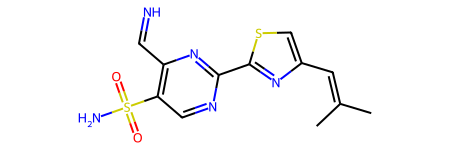

In [ ]:
gp = env.step(g, action)

print(gp)
ctx.fail_on_missing_attr = False  # For demonstration purposes, normally the agent would need to specify where the fragment is attached
ctx.graph_to_obj(gp)

While we've done this manually, this is what is handled by the `GraphSampler` class, itself used by `TrajectoryBalance`.

## Creating custom tasks

Let's look at how the `MakeRingsTask` is defined. This is a "toy" task that exists in the repo in order to test our per-atom-generation environment.

In particular, the reward of this task is simply the number of rings in the molecule. We will restrict the model to only output carbon atoms, and so it will be trained to create molecules with as many carbon rings as possible.

In [ ]:
from typing import Dict, List, Tuple
import torch
from rdkit import Chem
from rdkit.Chem.rdchem import Mol as RDMol
from torch import Tensor

# These are abstract classes/types
from gflownet import GFNTask, LogScalar, ObjectProperties
# Config stuff
from gflownet.config import Config, init_empty
# This is our per-atom-generation environment
from gflownet.envs.mol_building_env import MolBuildingEnvContext


class MakeRingsTask(GFNTask):
    """A toy task where the reward is the number of rings in the molecule."""

    def sample_conditional_information(self, n: int, train_it: int) -> Dict[str, Tensor]:
        # This method exists to initiate trajectories that may depend on different
        # conditional information. For example, we could tell the model to generate
        # molecules with a logP between 3 and 4, and penalize it (in the
        # cond_info_to_logreward method) if it doesn't.

        # Because we don't want to make the generation conditional on anything, we
        # provide a constant "encoding" vector. We also don't care about a reward
        # temperature, so provide a constant beta = 1
        return {"beta": torch.ones(n), "encoding": torch.ones(n, 1)}

    def compute_obj_properties(self, mols: List[RDMol]) -> Tuple[ObjectProperties, Tensor]:
        # This method computes object properties, these can be anything we want
        # and aren't the reward yet.
        # We return an (n, 1) scalar, as well as a (n,) tensor of bools indicating
        # whether the objects are valid. In our case, they all are, but the task
        # may choose to invalidate objects it doesn't want.
        rs = torch.tensor([m.GetRingInfo().NumRings() for m in mols]).float()
        return ObjectProperties(rs.reshape((-1, 1))), torch.ones(len(mols)).bool()

    def cond_info_to_logreward(self, cond_info: Dict[str, Tensor], obj_props: ObjectProperties) -> LogScalar:
        # This method transforms the object properties we computed above into a
        # LogScalar, more precisely a log-reward, which will be passed on to the
        # learning algorithm.
        scalar_logreward = torch.as_tensor(obj_props).squeeze().clamp(min=1e-30).log()
        return LogScalar(scalar_logreward.flatten())

Now that we've defined a task, we can easily creater a `GFNTrainer` class for it:

In [ ]:
# This is the basic GFN trainer that we'll reuse for our purposes
from gflownet.online_trainer import StandardOnlineTrainer

class MakeRingsTrainer(StandardOnlineTrainer):
    def set_default_hps(self, cfg: Config):
        # Here we choose some specific parameters, in particular, we don't want
        # molecules of more than 6 atoms, we we set
        cfg.algo.max_nodes = 6

        # This creates a lagged sampling model, see https://arxiv.org/abs/2310.19685
        cfg.algo.sampling_tau = 0.9

        # It is possible that our GFN generates impossible molecules. This will be
        # their logreward:
        cfg.algo.illegal_action_logreward = -75
        # Disable random actions
        cfg.algo.train_random_action_prob = 0.0
        cfg.algo.valid_random_action_prob = 0.0

    def setup_task(self):
        # The task we created above
        self.task = MakeRingsTask()

    def setup_env_context(self):
        # The per-atom generation context
        self.ctx = MolBuildingEnvContext(
            ["C"],  # We only allow carbons
            charges=[0],  # disable charge
            chiral_types=[Chem.rdchem.ChiralType.CHI_UNSPECIFIED],  # disable chirality
            num_rw_feat=0,  # disable random-walk features
            max_nodes=self.cfg.algo.max_nodes,  # Limit the number of atoms
            num_cond_dim=1,  # As per sample_conditional_information, this will be torch.ones((n, 1))
        )

We can now run the setup like this:

In [ ]:
config = init_empty(Config())
config.print_every = 1
config.log_dir = "./log_dir_rings"
config.device = dev
config.num_training_steps = 10
config.num_workers = 2
config.num_validation_gen_steps = 1

trial = MakeRingsTrainer(config, print_config=False)
trial.run()

08/09/2024 21:15:03 - INFO - logger - Starting training


INFO:logger:Starting training
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


08/09/2024 21:15:10 - INFO - logger - iteration 1 : offline_loss:0.00 online_loss:3718.26 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.08 loss:3718.26 n_loss:0.00 tb_loss:3718.26 batch_entropy:8.41 traj_lens:5.39 grad_norm:1241.59 grad_norm_clip:79.25 sampled_reward_avg:0.25 train_time:0.38 time_spent:7.01


INFO:logger:iteration 1 : offline_loss:0.00 online_loss:3718.26 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.08 loss:3718.26 n_loss:0.00 tb_loss:3718.26 batch_entropy:8.41 traj_lens:5.39 grad_norm:1241.59 grad_norm_clip:79.25 sampled_reward_avg:0.25 train_time:0.38 time_spent:7.01


08/09/2024 21:15:10 - INFO - logger - iteration 2 : offline_loss:0.00 online_loss:3433.65 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.12 loss:3433.65 n_loss:0.00 tb_loss:3433.65 batch_entropy:10.23 traj_lens:6.48 grad_norm:1563.11 grad_norm_clip:80.45 sampled_reward_avg:0.28 train_time:0.31 time_spent:0.39


INFO:logger:iteration 2 : offline_loss:0.00 online_loss:3433.65 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.12 loss:3433.65 n_loss:0.00 tb_loss:3433.65 batch_entropy:10.23 traj_lens:6.48 grad_norm:1563.11 grad_norm_clip:80.45 sampled_reward_avg:0.28 train_time:0.31 time_spent:0.39


08/09/2024 21:15:18 - INFO - logger - iteration 3 : offline_loss:0.00 online_loss:3212.42 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.15 loss:3212.42 n_loss:0.00 tb_loss:3212.42 batch_entropy:13.84 traj_lens:7.75 grad_norm:1704.75 grad_norm_clip:80.90 sampled_reward_avg:0.31 train_time:0.54 time_spent:7.55


INFO:logger:iteration 3 : offline_loss:0.00 online_loss:3212.42 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.15 loss:3212.42 n_loss:0.00 tb_loss:3212.42 batch_entropy:13.84 traj_lens:7.75 grad_norm:1704.75 grad_norm_clip:80.90 sampled_reward_avg:0.31 train_time:0.54 time_spent:7.55


08/09/2024 21:15:18 - INFO - logger - iteration 4 : offline_loss:0.00 online_loss:2874.05 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.19 loss:2874.05 n_loss:0.00 tb_loss:2874.05 batch_entropy:15.82 traj_lens:8.75 grad_norm:1634.40 grad_norm_clip:79.90 sampled_reward_avg:0.67 train_time:0.48 time_spent:0.78


INFO:logger:iteration 4 : offline_loss:0.00 online_loss:2874.05 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.19 loss:2874.05 n_loss:0.00 tb_loss:2874.05 batch_entropy:15.82 traj_lens:8.75 grad_norm:1634.40 grad_norm_clip:79.90 sampled_reward_avg:0.67 train_time:0.48 time_spent:0.78


08/09/2024 21:15:22 - INFO - logger - iteration 5 : offline_loss:0.00 online_loss:2290.17 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.22 loss:2290.17 n_loss:0.00 tb_loss:2290.17 batch_entropy:21.25 traj_lens:11.70 grad_norm:1367.84 grad_norm_clip:79.81 sampled_reward_avg:0.84 train_time:0.22 time_spent:3.84


INFO:logger:iteration 5 : offline_loss:0.00 online_loss:2290.17 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.22 loss:2290.17 n_loss:0.00 tb_loss:2290.17 batch_entropy:21.25 traj_lens:11.70 grad_norm:1367.84 grad_norm_clip:79.81 sampled_reward_avg:0.84 train_time:0.22 time_spent:3.84


08/09/2024 21:15:23 - INFO - logger - iteration 6 : offline_loss:0.00 online_loss:2616.69 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.25 loss:2616.69 n_loss:0.00 tb_loss:2616.69 batch_entropy:18.66 traj_lens:10.03 grad_norm:1731.98 grad_norm_clip:81.61 sampled_reward_avg:0.64 train_time:0.31 time_spent:0.39


INFO:logger:iteration 6 : offline_loss:0.00 online_loss:2616.69 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.25 loss:2616.69 n_loss:0.00 tb_loss:2616.69 batch_entropy:18.66 traj_lens:10.03 grad_norm:1731.98 grad_norm_clip:81.61 sampled_reward_avg:0.64 train_time:0.31 time_spent:0.39


08/09/2024 21:15:27 - INFO - logger - iteration 7 : offline_loss:0.00 online_loss:1629.80 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.29 loss:1629.80 n_loss:0.00 tb_loss:1629.80 batch_entropy:25.75 traj_lens:13.59 grad_norm:1036.43 grad_norm_clip:76.43 sampled_reward_avg:1.50 train_time:0.22 time_spent:4.38


INFO:logger:iteration 7 : offline_loss:0.00 online_loss:1629.80 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.29 loss:1629.80 n_loss:0.00 tb_loss:1629.80 batch_entropy:25.75 traj_lens:13.59 grad_norm:1036.43 grad_norm_clip:76.43 sampled_reward_avg:1.50 train_time:0.22 time_spent:4.38


08/09/2024 21:15:27 - INFO - logger - iteration 8 : offline_loss:0.00 online_loss:1740.40 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.32 loss:1740.40 n_loss:0.00 tb_loss:1740.40 batch_entropy:25.66 traj_lens:13.47 grad_norm:1276.44 grad_norm_clip:78.34 sampled_reward_avg:1.67 train_time:0.32 time_spent:0.39


INFO:logger:iteration 8 : offline_loss:0.00 online_loss:1740.40 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.32 loss:1740.40 n_loss:0.00 tb_loss:1740.40 batch_entropy:25.66 traj_lens:13.47 grad_norm:1276.44 grad_norm_clip:78.34 sampled_reward_avg:1.67 train_time:0.32 time_spent:0.39


08/09/2024 21:15:35 - INFO - logger - iteration 9 : offline_loss:0.00 online_loss:966.27 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.35 loss:966.27 n_loss:0.00 tb_loss:966.27 batch_entropy:30.94 traj_lens:16.84 grad_norm:665.17 grad_norm_clip:73.97 sampled_reward_avg:2.38 train_time:0.47 time_spent:8.14


INFO:logger:iteration 9 : offline_loss:0.00 online_loss:966.27 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.35 loss:966.27 n_loss:0.00 tb_loss:966.27 batch_entropy:30.94 traj_lens:16.84 grad_norm:665.17 grad_norm_clip:73.97 sampled_reward_avg:2.38 train_time:0.47 time_spent:8.14


08/09/2024 21:15:36 - INFO - logger - iteration 10 : offline_loss:0.00 online_loss:928.68 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.39 loss:928.68 n_loss:0.00 tb_loss:928.68 batch_entropy:33.86 traj_lens:17.23 grad_norm:764.12 grad_norm_clip:74.49 sampled_reward_avg:2.70 train_time:0.28 time_spent:0.39


INFO:logger:iteration 10 : offline_loss:0.00 online_loss:928.68 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.39 loss:928.68 n_loss:0.00 tb_loss:928.68 batch_entropy:33.86 traj_lens:17.23 grad_norm:764.12 grad_norm_clip:74.49 sampled_reward_avg:2.70 train_time:0.28 time_spent:0.39


In [ ]:
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 16)

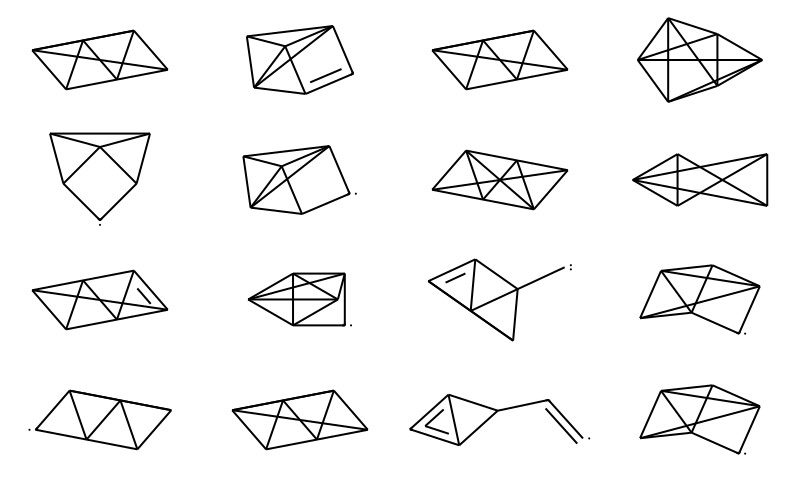

In [ ]:
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
MolsToGridImage(objs, molsPerRow=4, subImgSize=(200, 120))